# Noise2Void

## Overview 

[Noise2Void](#references) [1, 2] is a self-supervised denoising method. It trains by randomly masking
pixels in the input image and predicting their masked value from the surrounding pixels.

N2V relies on two fundamental hypotheses:

- The underlying structures are smooths (i.e. continuous)
- The noise is pixel-wise independent (i.e. the noise in one pixel is not correlated with
the noise in a neighboring pixel)

The corollary from these hypotheses is that if we consider the value of a pixel, $x$, as 
being the sum of the true signal, $s$, and a ceertain amount of noise, $\epsilon$, such 
that $x = s + \epsilon$, then:

- The true signal value $s$ can be estimated from the surrounding pixels
- The noise $\epsilon$ cannot be estimated from the surrounding pixels

Therefore, in cases where the hypotheses hold, if a pixel is masked, its noise cannot be
estimated from the surrounding pixels, while the true signal can. This is exactly how
N2V is trained!



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from careamics.transforms import N2VManipulate
from careamics_portfolio import PortfolioManager
from scipy.ndimage import convolve


def autocorrelation(x):
    """
    nD autocorrelation
    remove mean per-patch (not global GT)
    normalize stddev to 1
    value at zero shift normalized to 1...
    """
    x = (x - np.mean(x)) / np.std(x)
    x = np.fft.fftn(x)
    x = np.abs(x) ** 2
    x = np.fft.ifftn(x).real
    x = x / x.flat[0]
    x = np.fft.fftshift(x)
    return x


def get_hcorrelated_noise(shape, noise):
    purenoise = []
    noise_kernel = np.array([[1, 1, 1]]) / 3  ## horizontal correlations

    noise = convolve(noise, noise_kernel)

    purenoise = np.array(noise)
    purenoise = purenoise - purenoise.mean()

    return purenoise


# download file
portfolio = PortfolioManager()
files = portfolio.denoiseg.MouseNuclei_n0.download()
files.sort()

# load data
test_data = np.load(files[0])

## Training Noise2Void

Noise2Void is self-supervised, meaning that it trains on the data itself. It relies 
on a classical [UNet architecture](#references) [4], and applies a special augmentation 
called `N2V manipulate` that replaces the value of randomly-selected pixels with the 
value of one of their neighbours (see the left column in the next figure).

During training, the output of the network is compared to an image that is only 
comprised of the original pixels that were obfuscated during the augmentation. The loss
is only computed on these obfuscated pixels, which means that the network is trained 
specifically to predict the masked pixels values!

Below you can see two examples of the input to the network (left) and the masked pixels
used to compute the loss (right). The first example is a toy image that allows visualizing
the pixel replacement (it masks $2\%$ of the pixels). The second example is a realistic
image with the default N2V pixel manipulation parameters (e.g. $0.2\%$ of masked pixels).

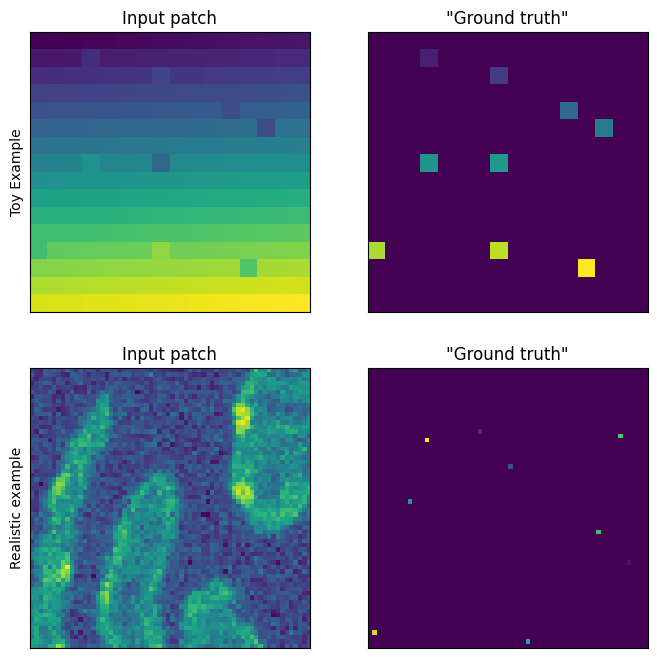

In [2]:
######### toy example
# array
scale = 16
patch = np.arange(scale**2).reshape((1, scale, scale))

# manipulate n2v
n2v_manipulate = N2VManipulate(roi_size=4, masked_pixel_percentage=2, seed=24)

# apply n2v manipulation
manipulated, _, mask = n2v_manipulate(patch)

######### real example
n2v_manipulate_real = N2VManipulate(seed=42)
scale = 32
real_patch = test_data["X_test"][3][:64, :64][np.newaxis, ...]
real_noisy = np.random.normal(0, 25, real_patch.shape)
real_noisy = real_patch + real_noisy
real_manipulated, _, real_mask = n2v_manipulate_real(real_noisy)

# show manipulated patch next to mask
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(manipulated.squeeze())
ax[0, 0].set_title("Input patch")
ax[0, 0].set_ylabel("Toy Example")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(mask.squeeze() * patch.squeeze())
ax[0, 1].set_title('"Ground truth"')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[1, 0].imshow(real_noisy.squeeze())
ax[1, 0].set_title("Input patch")
ax[1, 0].set_ylabel("Realistic example")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(real_mask.squeeze() * real_noisy.squeeze())
ax[1, 1].set_title('"Ground truth"')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

plt.show()

*Fig 1.: Noise2Void masking scheme. Top row: a toy example showcasing the pixel value
replacement of masked pixels (left), and the resulting mask used for supervision (right).
The mask contains the original values of the masked pixels. Bottom row: realistic
example with the default masking parameters (data from [3](#references)). CC-BY.* 


## Interpreting the loss

As described above, the loss is computed by calculating the mean squared error over the
masked pixels:

$$loss = \dfrac{1}{N_{masked}}\sum_{i, masked}(x'_{i}-x_{i})^{2}$$

where $N_{masked}$ is the total number of masked pixels, $x'_{i}$ is the network prediction
for the masked pixel $i$, and $x_{i}$ is the original noisy value of pixel $i$.

As opposed to supervised approaches, where the loss is computed with respect to a known
ground truth, N2V computes the loss based on a noisy signal. At the beginning
of the training the network usually learns within a few epochs an approximation of the 
structures in the image and the loss decreases sharply. Then, it rapidly reaches a plateau 
and oscillates around a particular loss value.

Because the loss is computed between prediction and noisy signal, its absolute value is
not informative for whether the network is properly trained. Likewise, oscillation on the 
plateau does not indicate that it does not learn anymore. 

The best way to assess the quality of the training is to look at the denoised images, 
potentially at different points during training, using the [checkpoints](). In practice, 
we often simply train long enough for the image to look properly denoised!

If the training loss is not too informative, what about the validation loss? It is 
basically the same. If your validation loss increases, however, that does mean you are
overfitting and might need to add more images to the training data.


## Predicting on the training set

We are usually told that training and validation images should not be used to assess
the performance (even qualitatively) of the network, because it was trained specifically
to perform well on them.

With Noise2Void, however, the network is trained without biasing it towards a ground-truth 
as it is trained on noisy pixels only. Therefore, it is perfectly fine to predict on the 
training images.


## Re-using a trained model

Noise2Void learns both the noise distribution in the image and a structural prior, that 
is to say how the structures in the image look. As with most deep learning approaches, if you try
applying a trained neural network on images that are different from the training set, the
network will most likely fail and produce results of lesser quality.

This will happen with N2V, for example, if the noise distribution is different in the 
new images, or if they contain different structures. Fortunately, N2V is quick to train, 
so you can train a single network for each new experiment!


## Why do N2V predictions sometimes look blurry?

The absence of noise can by itself make images look slightly blurry. If some regions of
your data look unreasonably blurry, you might be encountering the a case of regression to
the mean.

For each noisy image, we often say that there is a whole distribution of possible denoised
images. In particular, for strongly degraded images, even different structures can produce
the same noisy patch. 

Because of this, a network trained with the mean squared error, such as N2V, will tend
to predict the average of all possible denoised images. This is why the prediction can
often look blurry and washed out. For approaches that predict single instances from the 
distribution of possible denoised images, check out [DivNoising]() or [HDN]().


## Assessing quality of results

Denoising is a difficult task to assess quantitatively. The most common and more accurate
way to estimate the performances of a network is to compare its output with a ground truth
image. That means that you need to acquire images with and without noise. This can be done
by acquiring with more laser power, longer exposure time, or by averaging multiple images.
That is, however, cumbersome and often impossible.

There are other ways perform controls on the quality of the denoising.

### Quality assessment by inspecting the residuals

The residuals are the pixel intensity removed from the original image by the network:

$$res = image - pred$$

They correspond to the subtraction of the prediction from the original image. If the
residual show details of the image structure, then the training went wrong or the network 
did not train for long enough.

<p align="center">
  <img src="https://raw.githubusercontent.com/CAREamics/careamics-examples/1221cb91e54fc20f34fcd5ab8117a32434020bb0/algorithms/n2v/sem_n2v_residuals_comparison.png" width="700"/>
</p>

*Fig 2.: The residuals are a good indicator of successful training. Top row: input image (left),
prediction (center) and corresponding residuals (right) after one training epoch. The residuals
show structures. Bottom row: same after 50 epochs, there is no visible structure that is not pure
noise. CC-BY.* 


Note that in the presence of Poisson noise (a.k.a shot noise), the amplitude
of noise scales with the square root of the signal. Therefore, the residuals can still
be modulated by the structures in the image, especially the bright ones. Please note 
that a property of the residuals is that the sum of its pixels should always be 
close to zero: even if some areas of the residuals look brighter, on closer inspection, 
you should see a lot of very dark pixels in this very region.


### Assessing quality by training multiple networks

As Noise2Void training is stochastic, in order to assess whether structures are really in your 
image, you can perform different types of experiments:

- Split your images in several subsets and train independent networks on each of them. 
Compare the results.
- Train multiple randomly initialized networks on your training data and compare the results.

## Limitations

### Pixel-wise independent noise

It might happen that the noise in your images is not pixel-wise independent. This is sometimes the case
with sCMOS camera or point-scanning microscopy methods. In such cases, Noise2Void might
introduce small artefacts or simply reinforce the correlated pattern in the denoised
image. 

To estimate whether the noise is correlated, one can perform image autocorrelation and 
inspect the shape of the central peak in the distribution. The next figure shows two 
examples of the same image with artificial Gaussian noise. In the second 
one, we introduced a correlation in the Gaussian noise, leading to an horizontal line in
the autocorrelation image.

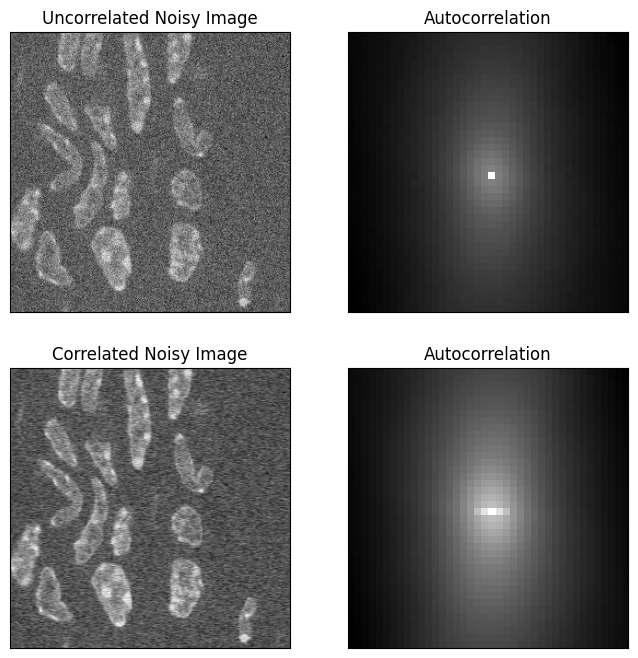

In [4]:
# compute noise and autocorrelation
clean_img = test_data["X_test"][0]
clean_img_autocorr = autocorrelation(clean_img)

# create a noisy image by adding 0 mean gaussian noise
sigma = 50
noisy = np.random.normal(0, sigma, clean_img.shape)
noisy_img = clean_img + noisy
noisy_img_autocorr = autocorrelation(noisy_img)

# add correlated noise
correlated_noise = get_hcorrelated_noise(clean_img.shape, noisy)
correlated_noisy_img = clean_img + correlated_noise
correlated_noisy_img_autocorr = autocorrelation(correlated_noisy_img)

# show images in one column and their correlation in the other
# crop the correlation around (0, 0)
midpoint = clean_img.shape[0] // 2
crop_size = 20
slices = (
    slice(midpoint - crop_size, midpoint + crop_size),
    slice(midpoint - crop_size, midpoint + crop_size),
)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(noisy_img, cmap="gray")
ax[0, 0].set_title("Uncorrelated Noisy Image")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(noisy_img_autocorr[slices], cmap="gray")
ax[0, 1].set_title("Autocorrelation")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[1, 0].imshow(correlated_noisy_img, cmap="gray")
ax[1, 0].set_title("Correlated Noisy Image")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(correlated_noisy_img_autocorr[slices], cmap="gray")
ax[1, 1].set_title("Autocorrelation")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
plt.show()

*Fig 3.: Structured noise. Top row: image with uncorrelated noise (left) and its 
autocorrelation (close-up on the zero-shift component). Bottom row: same images with
correlations introduced in the noise component. CC-BY.* 


### Checkerboard artefacts

Checkerboard artefacts [5] sometimes occur with Noise2Void. This effect is most prominent in
the presence of salt and pepper noise or hot pixels in sCMOS cameras. They are 
characterized by small cross patterns in the denoised image (see figure 4). To reduce the
presence of these artefacts, you can use [N2V2](../n2v2/N2V2).

<p align="center">
  <img src="https://raw.githubusercontent.com/CAREamics/careamics-examples/main/algorithms/n2v2/n2v_prediction_checkerboard.png" width="700"/>
</p>

*Fig 4.: Checkerboard artefacts. The figure shows a noisy image crop (left), a noisy
close-up (center) and the corresponding Noise2Void prediction (right). While the denoising was effective,
a distinctive checkerboard pattern nonetheless appears in the Noise2Void prediction. CC-BY.* 




## References

[1] Alexander Krull, Tim-Oliver Buchholz, and Florian Jug. "Noise2Void - learning denoising
from single noisy images." CVPR, 2019. [link](https://openaccess.thecvf.com/content_CVPR_2019/html/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.html)

[2] Joshua Batson, and Loic Royer. "Noise2Self: Blind denoising by self-supervision." 
MLR, 2019. [link](http://proceedings.mlr.press/v97/batson19a.html)

[3] Tim-Oliver Buchholz, Mangal Prakash, Deborah Schmidt, Alexander Krull, and Florian Jug. "Denoiseg: joint denoising and segmentation." ECCV, 2020. [link](https://link.springer.com/chapter/10.1007/978-3-030-66415-2_21)

[4] Olaf Ronneberger, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for 
biomedical image segmentation." MICCAI, 2015. [link](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28)

[5] Eva Höck, Tim-Oliver Buchholz, Anselm Brachmann, Florian Jug, and Alexander Freytag. "N2V2 - Fixing Noise2Void Checkerboard Artifacts with Modified Sampling Strategies and a Tweaked Network Architecture." ECCV, 2022. [link](https://link.springer.com/chapter/10.1007/978-3-031-25069-9_33)

